### Context

To minimize loss from the bank’s perspective, the bank needs a decision rule regarding whom to approve the loan and whom not to. An applicant’s demographic and socio-economic profiles are considered by loan managers before a decision is taken regarding his/her loan application.
In this dataset, each entry represents a person who takes credit from a bank. Each person is classified as a good or bad credit risk according to the set of attributes. 

### Objective
The objective is to build a predictive model on this data to help the bank decide on whether to approve a loan to a prospective applicant.

### Dataset
- `Age` (Numeric: Age in years)
- `Sex` (Categories: male, female)
- `Job` (Categories: unskilled and non-resident, unskilled and resident, skilled, highly skilled)
- `Housing` (Categories: own, rent, or free)
- `Saving accounts` (Categories: little, moderate, quite rich, rich)
- `Checking account` (Categories: little, moderate, rich)
- `Credit amount` (Numeric: Amount of credit in DM - Deutsche Mark)
- `Duration` (Numeric: Duration for which the credit is given in months)
- `Purpose` (Categories: car, furniture/equipment,radio/TV, domestic appliances, repairs, education, business, vacation/others)
- `Risk` (0 - Person is not at risk, 1 - Person is at risk(defaulter))

#### Import Libraries

In [1]:
# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data
from sklearn.model_selection import train_test_split


# To build model for prediction
from sklearn.linear_model import LogisticRegression

# To get diferent metric scores

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
)

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

#### Load Dataset

In [2]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
data = pd.read_csv("data/18_German_Credit.csv")

In [3]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk,Purpose
0,67,male,skilled,own,little,little,1169,6,0,radio/TV
1,22,female,skilled,own,little,moderate,5951,48,1,radio/TV
2,49,male,unskilled_and_non-resident,own,little,little,2096,12,0,education
3,45,male,skilled,free,little,little,7882,42,0,furniture/equipment
4,53,male,skilled,free,little,little,4870,24,1,car


#### Data size

In [4]:
data.shape

(1000, 10)

#### Check the data types of the columns in the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Risk              1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


- There are total 10 columns and 1,000 observations in the dataset
- We have only three continuous variables - Age, Credit Amount, and Duration.
- All other variables are categorical.
- There no missing values in the dataset.

#### Summary of the data

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
Risk,1000.0,0.300,0.458487,0.0,0.0,0.0,1.00,1.0


**Observations**

- Mean value for the age column is approx 35 and the median is 33. This shows that majority of the customers are under 35 years of age.
- Mean amount of credit is approx 3,271 but it has a wide range with values from 250 to 18,424. We will explore this further in univariate analysis.
- Mean duration for which the credit is given is approx 21 months.

In [7]:
# Making a list of all catrgorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts(normalize=True))
    print("-" * 40)

Sex
male      0.69
female    0.31
Name: proportion, dtype: float64
----------------------------------------
Job
skilled                       0.630
unskilled_and_non-resident    0.222
highly skilled                0.148
Name: proportion, dtype: float64
----------------------------------------
Housing
own     0.713
rent    0.179
free    0.108
Name: proportion, dtype: float64
----------------------------------------
Saving accounts
little        0.786
moderate      0.103
quite rich    0.063
rich          0.048
Name: proportion, dtype: float64
----------------------------------------
Checking account
moderate    0.472
little      0.465
rich        0.063
Name: proportion, dtype: float64
----------------------------------------
Purpose
car                    0.337
radio/TV               0.280
furniture/equipment    0.181
business               0.097
education              0.059
repairs                0.022
domestic appliances    0.012
vacation/others        0.012
Name: proportion, dtype: fl

- `Sex` We have more male customers (69%) as compared to female customers (31%)
- `Job` Majority are skilled 63%
- `Housing` 71% own Home, which is majority
- `Saving accounts` 78% have little savings in their Savings Account, followed by moderate Savings which is 10%
- `Checking account` This is more evenly distributed between moderate (47%) and little (46.5%)
- `Purpose` - Most of the customers took loan for big item like Car (33.7%), 28% took for small items like radio/TV
- `Risk` - 30% of customers are at risk 

#### Exploratory Data Analysis

#### Univariate analysis

In [8]:
# Function to create a histogram and boxplot combined for visualization of numerical features
def histogram_boxplot(data, feature, figsize=(10, 5)):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (10,5))
    
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize)  # creating the 2 subplots
    
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="lightgreen")  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(data=data, x=feature, kde=True, ax=ax_hist2, color='skyblue')  # For histogram
    
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")  # Add median to the histogram

#### Observation on `Age` 

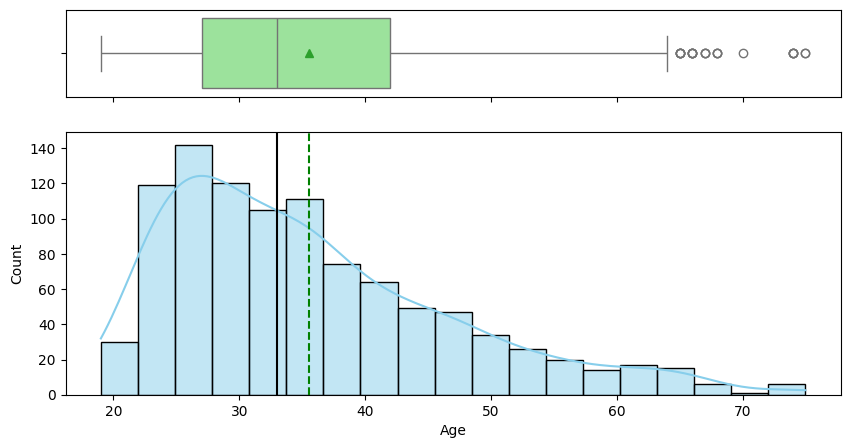

In [9]:
histogram_boxplot(data, "Age")

*The distribution of age is right-skewed with outliers which seems realistic*

#### Observation on `Credit Amount`

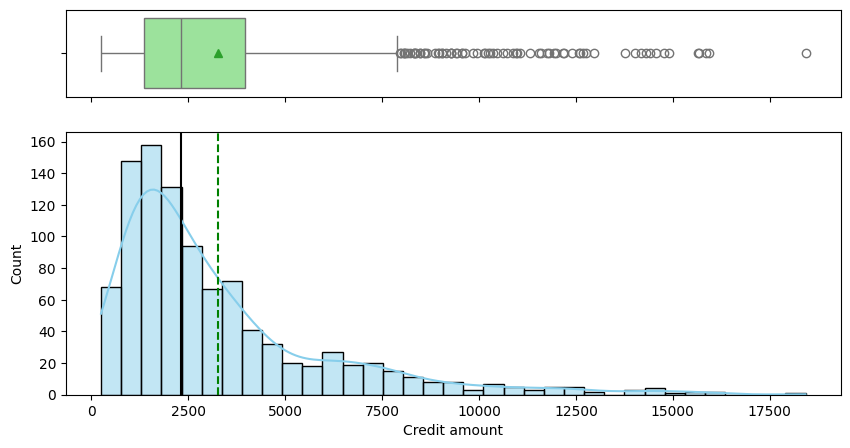

In [10]:
histogram_boxplot(data, "Credit amount")

*The distribution of the credit amount is right-skewed, with outliers at the right end. They seem very realistic*

#### Observations on `Duration`

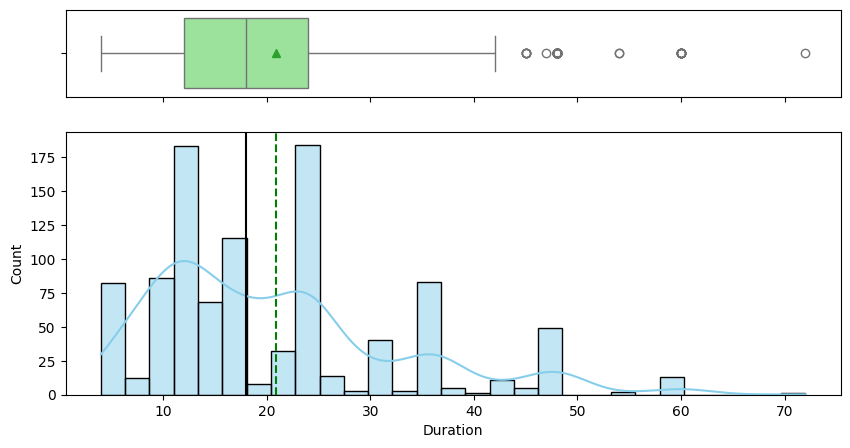

In [11]:
histogram_boxplot(data, "Duration")

*The distribution of the duration for which the credit is given is right-skewed*

In [12]:
# Function to plot count and percentage barplots side by side
def plot_count_and_percentage_barplot(data, column, figsize=(12, 5)):
    """
    Plots two countplots side by side: one with count labels, one with percentage labels.
    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column to plot.
        figsize (tuple): Figure size for the plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    categories = data[column].value_counts().index
    total = len(data)
    
    # Countplot with count labels
    ax1 = sns.countplot(data=data, x=column, hue=column, order=categories, ax=axes[0], palette='Set2')
    axes[0].set_title('Counts per ' + column)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=90)
    for p in ax1.patches:
        count = int(p.get_height())
        ax1.annotate(str(count), (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black')
    
    # Countplot with percentage labels
    ax2 = sns.countplot(data=data, x=column, hue=column, order=categories, ax=axes[1], palette='Set2')
    axes[1].set_title('Percentage per ' + column)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Percentage')
    axes[1].tick_params(axis='x', rotation=90)
    for p in ax2.patches:
        percent = 100 * p.get_height() / total
        ax2.annotate(f'{percent:.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='blue')
    
    plt.tight_layout()
    plt.show()

#### Observations on `Risk`

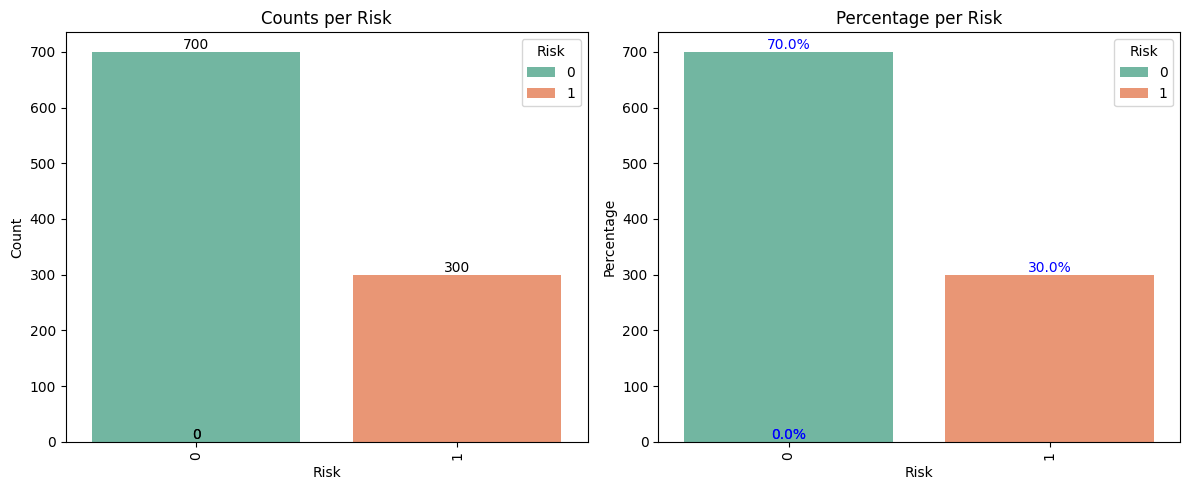

In [13]:
plot_count_and_percentage_barplot(data, "Risk")

*Data is imbalanced. 70% with no risk, and 30% risky*

#### Observations on `Sex` of Customers

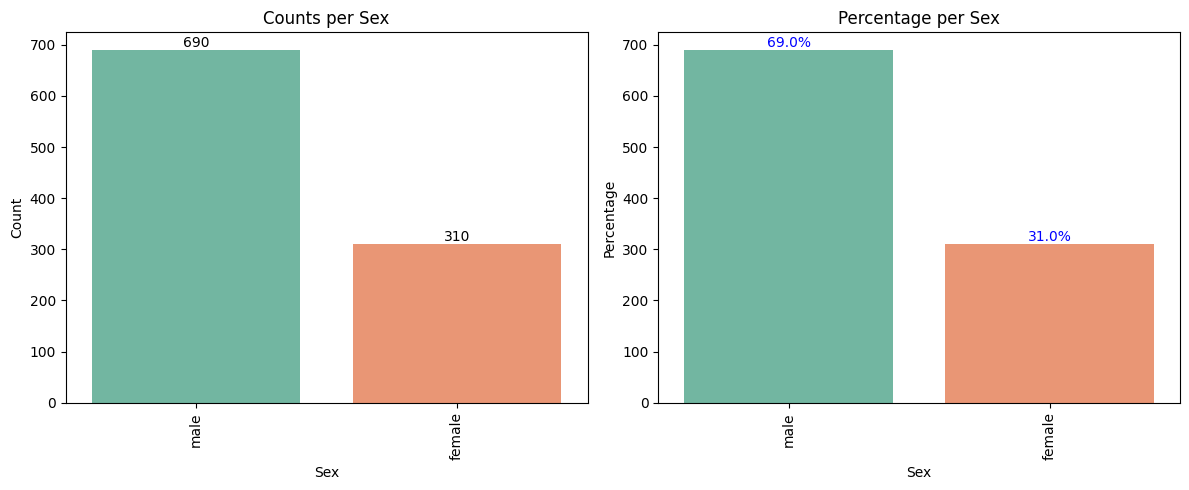

In [14]:
plot_count_and_percentage_barplot(data, "Sex")

*Male Customers take more credit based on the data*

#### Observations on `Housing`

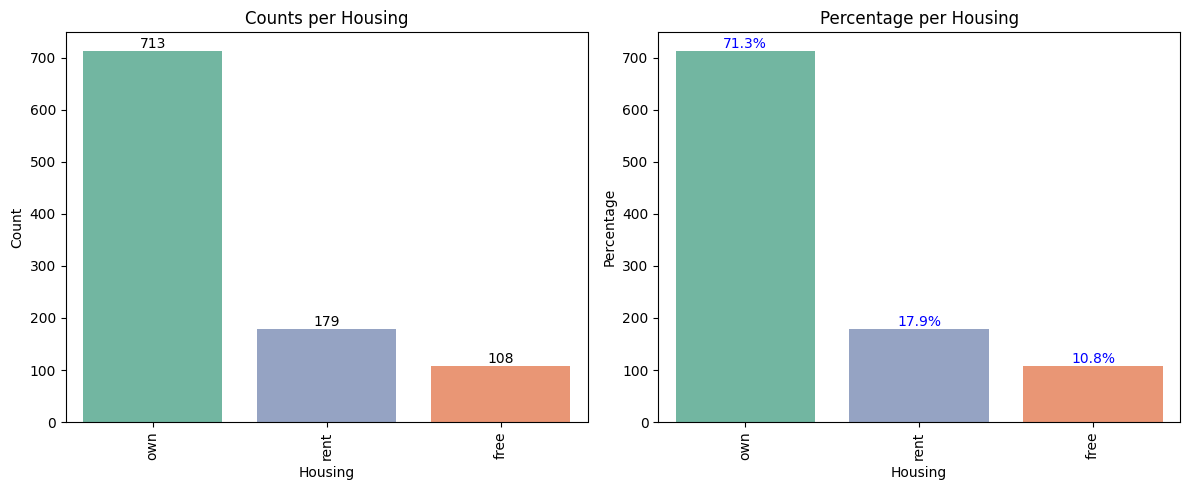

In [15]:
plot_count_and_percentage_barplot(data, "Housing")

*Major of the customers, approx 71%, who take credit have their own house. Approx 18% customers are living in a rented house*

#### Observations on `Job`

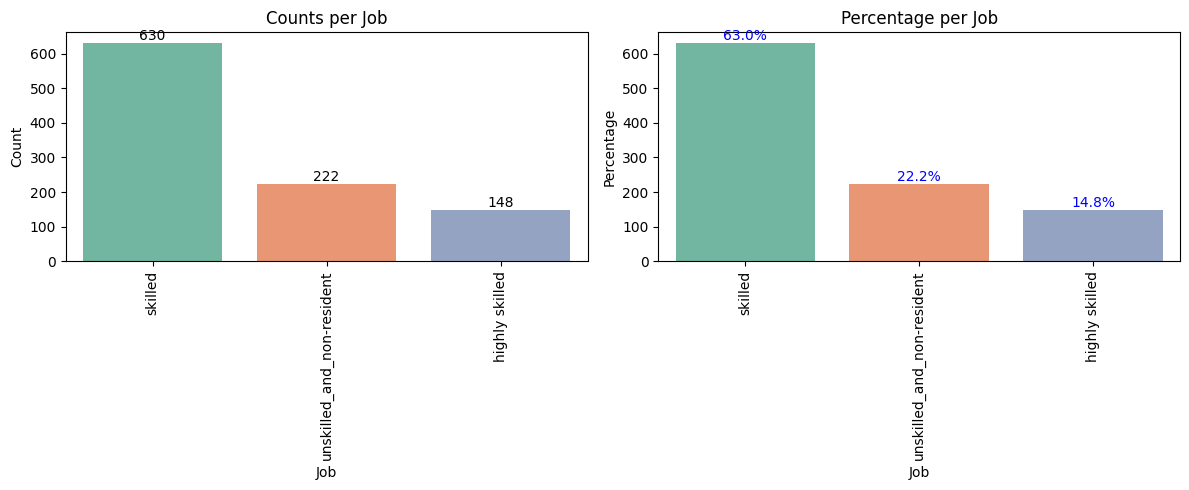

In [16]:
plot_count_and_percentage_barplot(data, "Job")

*Majority of the customers i.e. 63% fall into the skilled category. 15% are hightly skilled and 22% with unskilled and non resident*

#### Observations on `Saving accounts`

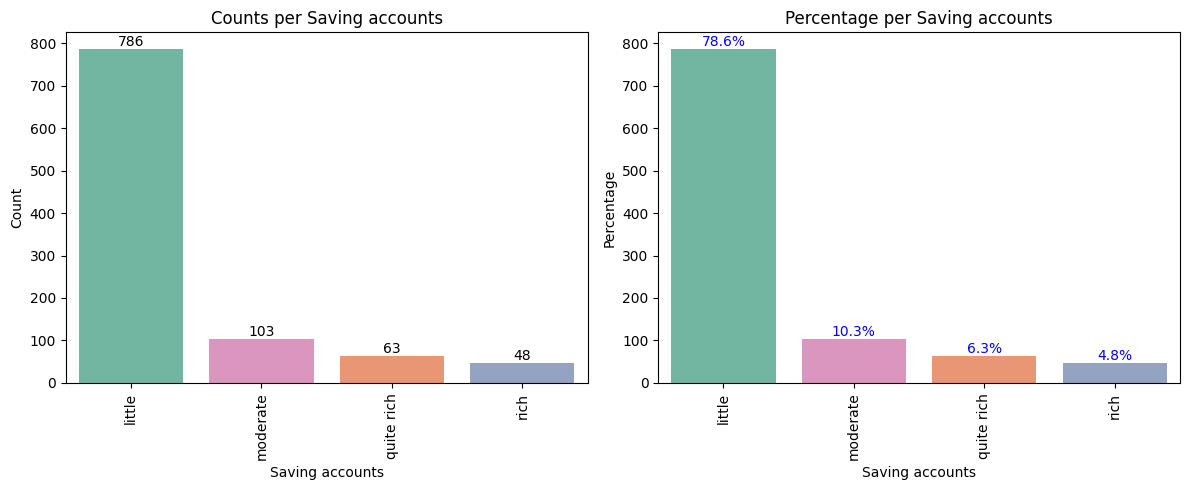

In [17]:
plot_count_and_percentage_barplot(data, "Saving accounts")

*78.6% with little savings, 10% with moderate*

#### Observations on `Checking account`

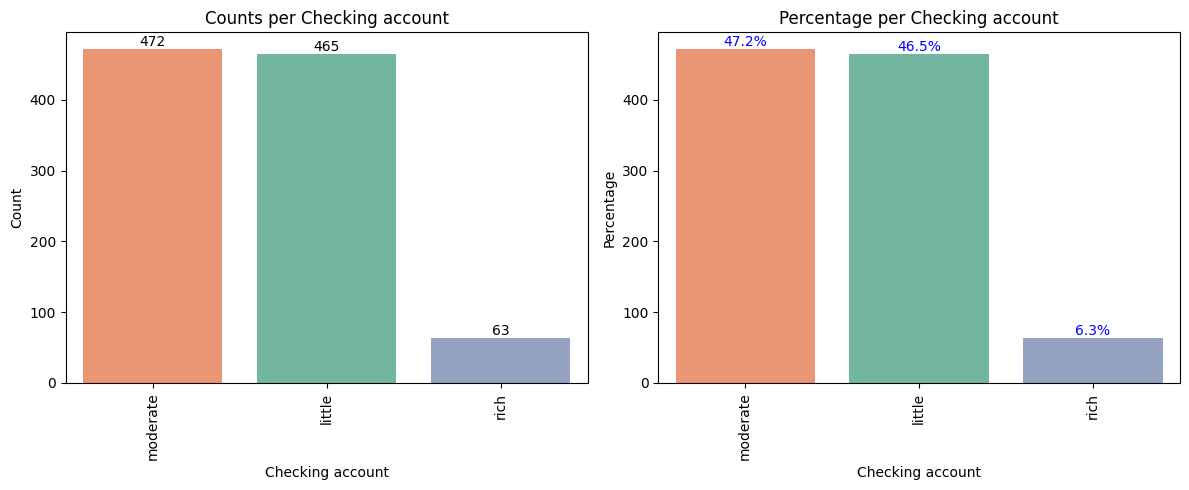

In [18]:
plot_count_and_percentage_barplot(data, "Checking account")

*customers with moderate and little money in their checking account are almost equal*

#### Observations on `Purpose`

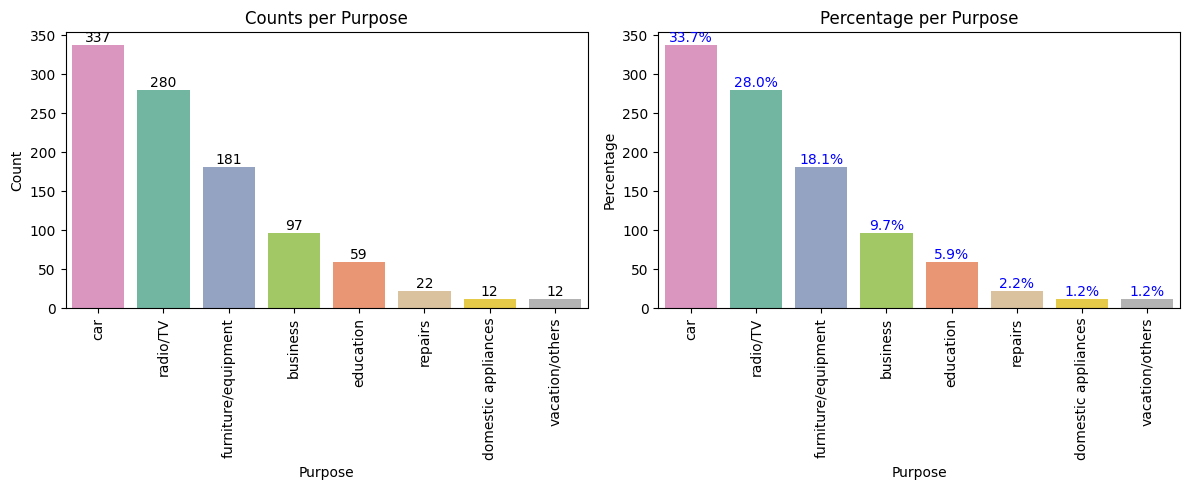

In [19]:
plot_count_and_percentage_barplot(data, "Purpose")

*Interestingly 34% of customers took credit for big item like car, 28% took for small item like TV or Radio. Almost 10% took for business and 6% for education*

#### Bivariate Analysis

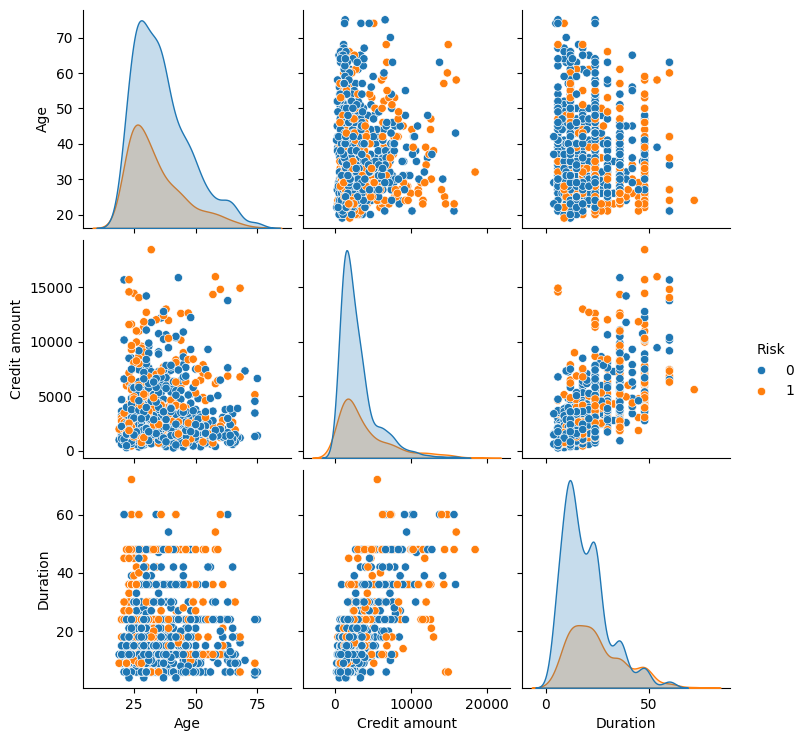

In [20]:
sns.pairplot(data, hue="Risk")
plt.show()

*There are overlaps i.e., no clear distinction in the distribution of variables for people who have defaulted and did not default*

In [21]:
# Function to plot distributions with respect to target
def distribution_plot_wrt_target(data, predictor, target):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    target_uniq = data[target].unique()

    axs[0, 0].set_title(f"Distribution of {predictor} for {target} = {target_uniq[0]}")
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor, kde=True, ax=axs[0, 0],
        color="teal", stat="density"
    )

    axs[0, 1].set_title(f"Distribution of {predictor} for {target} = {target_uniq[1]}")
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor, kde=True, ax=axs[0, 1],
        color="orange", stat="density"
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(
        data=data, x=target, y=predictor,
        ax=axs[1, 0], hue=target, palette="gist_rainbow", legend=False
    )

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data, x=target, y=predictor,
        ax=axs[1, 1], hue=target, showfliers=False, palette="gist_rainbow", legend=False
    )

    plt.tight_layout()
    plt.show()


#### `Risk` vs `Age`

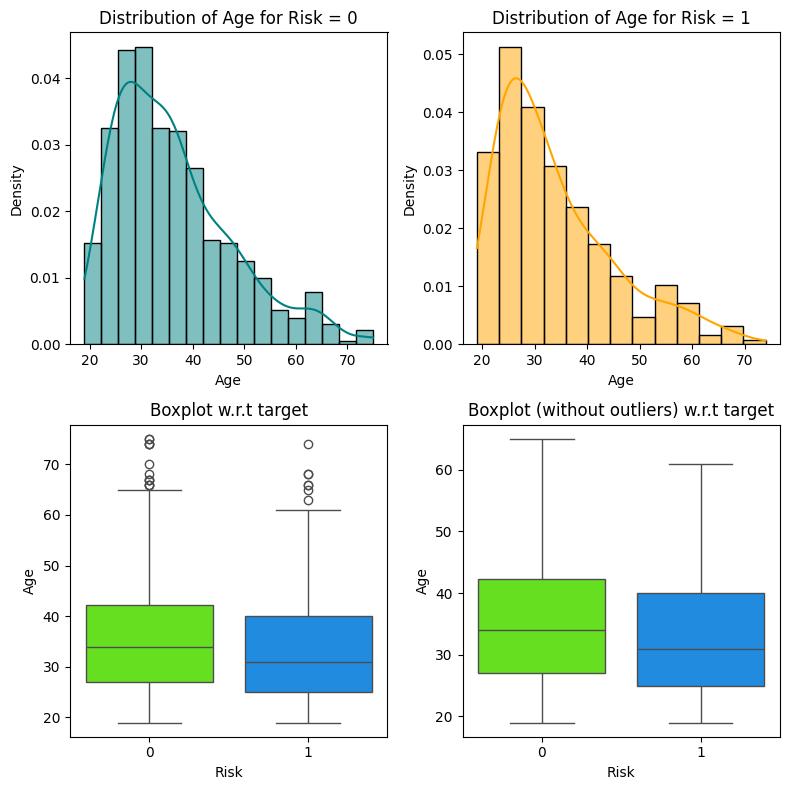

In [22]:
distribution_plot_wrt_target(data, "Age", "Risk")

*We can see that the median age of defaulters is less than the median age of non-defaulters, which means younger customers are more likely to default*

#### `Risk` vs `Credit amount`

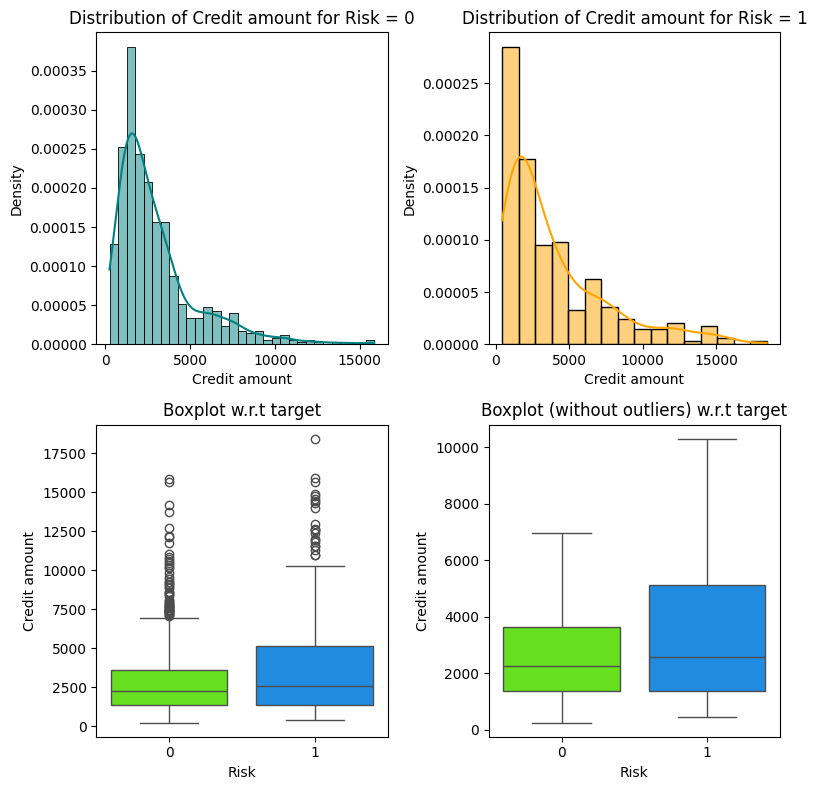

In [23]:
distribution_plot_wrt_target(data, "Credit amount", "Risk")

*This shows that customers with high credit amount are more likely to default*

#### `Risk` vs `Duration`

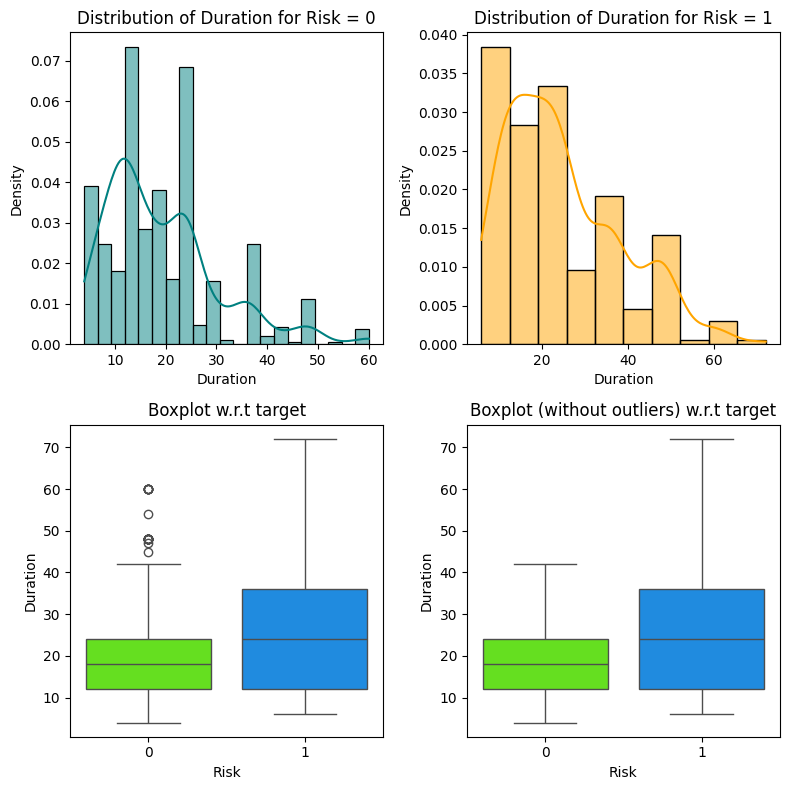

In [24]:
distribution_plot_wrt_target(data, "Duration", "Risk")

*We can see that the second and third quartiles of duration of defaulters is much more than the second and third quartiles duration of non-defaulters. Customers with high duration are more likely to default.*

In [25]:
# function to plot stacked percentage bar chart
def plot_stacked_percentage_bar(data, x_col, hue_col, colormap='tab20', figsize=(6, 4), title=None):
    """
    Plots a stacked bar chart showing percentage distribution of hue_col within each x_col category.

    Parameters:
    - data: pandas DataFrame
    - x_col: column name for x-axis categories (e.g., 'Risk')
    - hue_col: column name for stacked segments (e.g., 'Sex')
    - colormap: matplotlib colormap name (default: 'tab20')
    - figsize: tuple for figure size
    - title: optional plot title
    """
    # Group and calculate percentages
    grouped = data.groupby([x_col, hue_col]).size().unstack(fill_value=0)
    percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Plot
    ax = percentages.plot(kind='bar', stacked=True, figsize=figsize, colormap=colormap)

    plt.ylabel('Percentage')
    plt.title(title or f'{x_col} Distribution by {hue_col} (Stacked Percentage)')
    # Place legend outside the plot to avoid overlap
    plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### `Risk` vs `Sex`

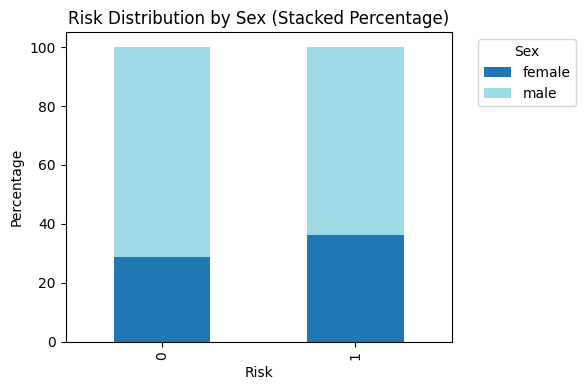

In [26]:
plot_stacked_percentage_bar(data, x_col='Risk', hue_col='Sex')

*We saw earlier that the percentage of male customers is more than the female customers. This plot shows that female customers are more likely to default as compared to male customers.*

#### `Risk` vs `Job`

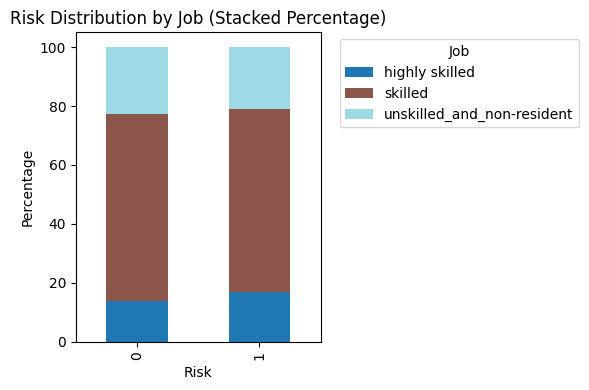

In [27]:
plot_stacked_percentage_bar(data, x_col='Risk', hue_col='Job')

*Seems Highly Skilled are slightly more likely to default*

#### `Risk` vs `Housing`

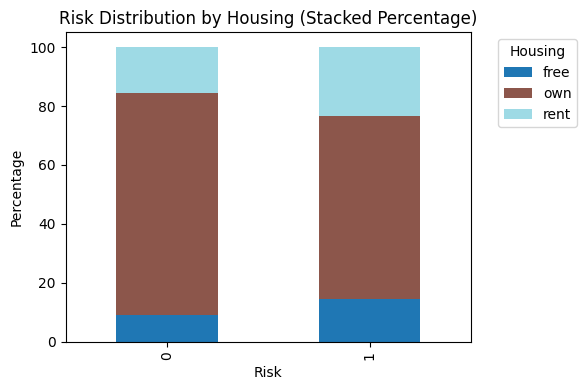

In [28]:
plot_stacked_percentage_bar(data, x_col='Risk', hue_col='Housing')

*Owning house is less likely to default, Renting and Free is more*

#### `Risk` vs `Saving accounts`

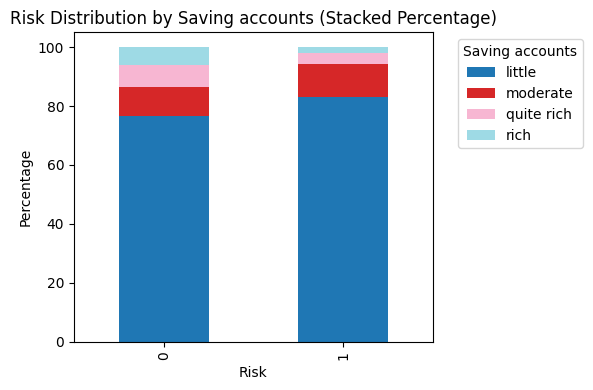

In [29]:
plot_stacked_percentage_bar(data, x_col='Risk', hue_col='Saving accounts')

*As se saw earlier, customers with little Savings are more likely to default*

#### `Risk` vs `Checking account`

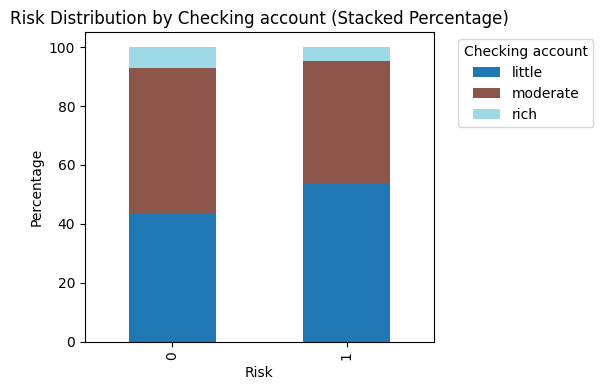

In [30]:
plot_stacked_percentage_bar(data, x_col='Risk', hue_col='Checking account')

*As se saw earlier, customers with little Savings are more likely to default*

#### `Risk` vs `Purpose`

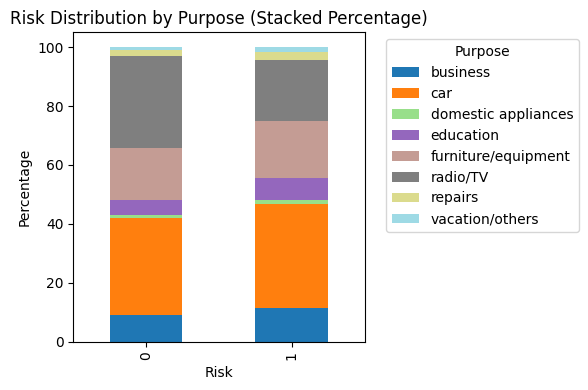

In [31]:
plot_stacked_percentage_bar(data, x_col='Risk', hue_col='Purpose')

*Cars and Business credits are more likely to be defaulted maybe as the amount is more*

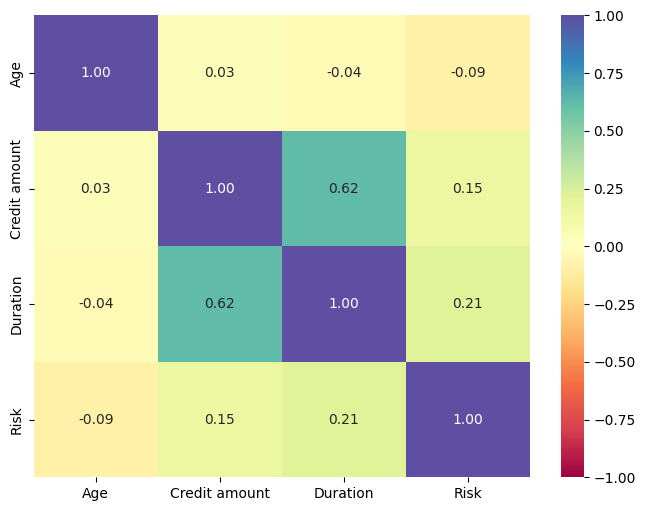

In [32]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

*Credit amount and duration have positive correlation which makes sense as customers might take the credit for longer duration if the amount of credit is high. Other variables have no significant correlation between them.*

#### Model evaluation criterion

#### Model can make wrong predictions as:

1. Predicting a customer is not going to default but in reality the customer will default - Loss of resources (False Negative - FN)
2. Predicting a customer is going to default but in reality the customer will not default - Loss of opportunity (False Positive - FP)


#### Which Loss is greater ? 

* Loss of resources will be the greater loss as the bank will be losing on its resources/money.

#### How to reduce this loss i.e need to reduce False Negatives ?

*Company would want to **reduce false negatives**, this can be done by **maximizing the Recall**. Greater the recall lesser the chances of false negatives.*

#### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_sklearn_with_threshold function will be used to check the model performance of models. 
* The confusion_matrix_sklearn_with_threshold function will be used to plot confusion matrix.

In [33]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn

def model_performance_classification_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics, based on the threshold specified, to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # predicting using the independent variables
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    pred = np.round(pred_thres)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


In [34]:
# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

#### Data Preparation

In [35]:
# Converting monthly values to yearly
data["Duration"] = data["Duration"] / 12

In [36]:
X = data.drop("Risk", axis=1)
Y = data["Risk"]

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

#### Logistic Regression

In [37]:
# There are different solvers available in Sklearn logistic regression
# The newton-cg solver is faster for high-dimensional data

model = LogisticRegression(solver="newton-cg", random_state=1) # newtol-cg - Newton-Conjugate Gradient method. 
lg = model.fit(X_train, y_train)

In [38]:
lg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [39]:
lg.coef_  # coefficients of the model

array([[-3.46509137e-02,  2.50106837e-05,  3.54875350e-01,
        -3.87528805e-01,  9.85644061e-03,  1.39462987e-01,
        -8.13700893e-01, -3.76663692e-01,  8.00756757e-03,
        -6.71340565e-01, -8.54963680e-01, -2.14326476e-01,
        -3.04511723e-01, -6.46970944e-02,  2.14848939e-01,
         3.09393859e-01, -3.94773668e-01, -6.63764134e-01,
        -4.36108623e-02,  2.07487145e-01]])

#### Finding the coefficients

In [40]:
log_odds = lg.coef_[0]
pd.DataFrame(log_odds, X_train.columns, columns=["coef"]).T

,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
coef,-0.034651,0.000025,0.354875,-0.387529,0.009856,0.139463,-0.813701,-0.376664,0.008008,-0.671341,-0.854964,-0.214326,-0.304512,-0.064697,0.214849,0.309394,-0.394774,-0.663764,-0.043611,0.207487


#### Coefficient interpretations

* Coefficients of Duration, Credit amount and some categorical levels of Purpose and Job are positive, an increase in these will lead to an increase in chances of a customer being a defaulter. 
* Coefficients of Age, Sex_male, Housing, Saving_accounts, and some categorical levels of Purpose and Job is negative, an increase in these will lead to a decrease in chances of a customer being a defaulter.

####  Converting coefficients to odds

* The coefficients of the logistic regression model are in terms of log(odd), to find the odds we have to take the exponential of the coefficients. 
* Therefore, **odds =  exp(b)**
* The percentage change in odds is given as **odds = (exp(b) - 1) * 100**

**Odds from coefficients**

In [41]:
# converting coefficients to odds
odds = np.exp(lg.coef_[0])

# finding the percentage change
perc_change_odds = (np.exp(lg.coef_[0]) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train.columns).T

,Age,Credit amount,Duration,Sex_male,Job_skilled,Job_unskilled_and_non-resident,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
Odds,0.965943,1.000025,1.426003,0.678732,1.009905,1.149656,0.443215,0.686147,1.008040,0.511023,0.425299,0.807085,0.737483,0.937351,1.239675,1.362599,0.673833,0.514909,0.957326,1.230582
Change_odd%,-3.405745,0.002501,42.600289,-32.126792,0.990518,14.965625,-55.678526,-31.385321,0.803971,-48.897694,-57.470136,-19.291515,-26.251662,-6.264865,23.967462,36.259894,-32.616747,-48.509051,-4.267358,23.058190


#### Coefficient interpretations

* `Age`: Holding all other features constant a unit change in Age will decrease the odds of a customer being a defaulter by 0.96 times or a 3.40% decrease in the odds.
* `Credit amount`: Holding all other features constant a unit change in Credit amount will increase the odds of a customer being a defaulter by 1.00 times or a 0.003% increase in the odds.
* `Duration`: Holding all other features constant a unit change in Duration will increase the odds of a customer being a defaulter by 1.42 times or a 42.60% increase in the odds.
* `Sex`: The odds of a male customer being a defaulter 0.68 times less than a female customer or 32.1% fewer odds than female.
* `Housing`: The odds of a customer who has own house being a defaulter is 0.44 times less than the customer who lives in a house provided by his organization (Housing - free) or 55.67% fewer odds of being a defaulter. Similarly, The odds of a customer who lives in a rented place being a defaulter is 0.68 times less than the customer who lives in a house provided by his organization (Housing - free) or 31.37% fewer odds of being a defaulter. [Keeping housing_free as reference]

`Interpretation for other attributes can be made similarly.`

#### Checking model performance on training set

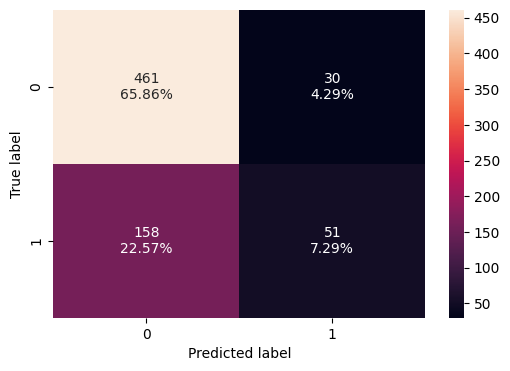

In [42]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_train, y_train)

In [43]:
log_reg_model_train_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.731429,0.244019,0.62963,0.351724


#### ROC-AUC

* ROC-AUC on training set

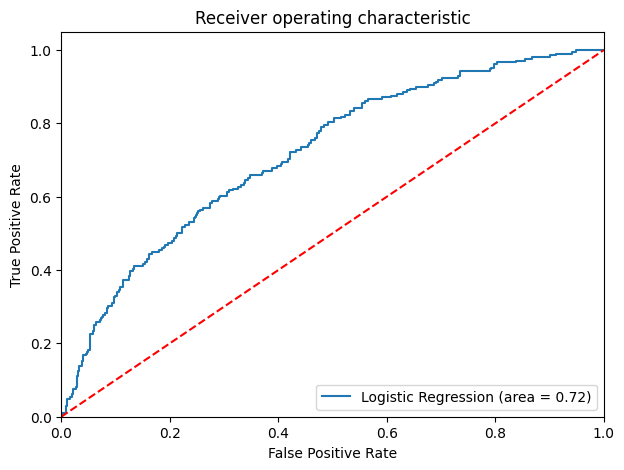

In [44]:
logit_roc_auc_train = roc_auc_score(y_train, lg.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

* Logistic Regression model is giving a good performance on training set but the recall is low.

#### Model Performance Improvement

* Let's see if the recall score can be improved further, by changing the model threshold using AUC-ROC Curve.

#### Optimal threshold using AUC-ROC curve

In [45]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_train, lg.predict_proba(X_train)[:, 1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.2444038045903316


#### Checking model performance on training set

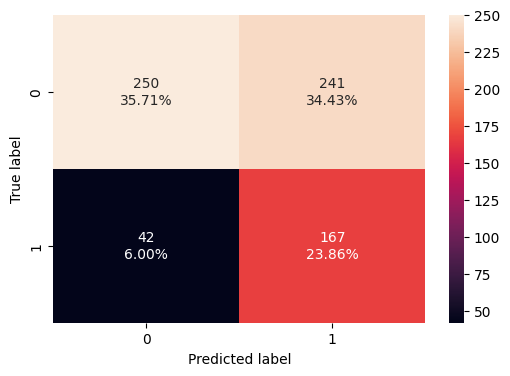

In [46]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)

In [47]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.595714,0.799043,0.409314,0.541329


* Model performance has improved significantly on training set.
* Model is giving a recall of 0.79 on the training set.

#### Let's use Precision-Recall curve and see if we can find a better threshold

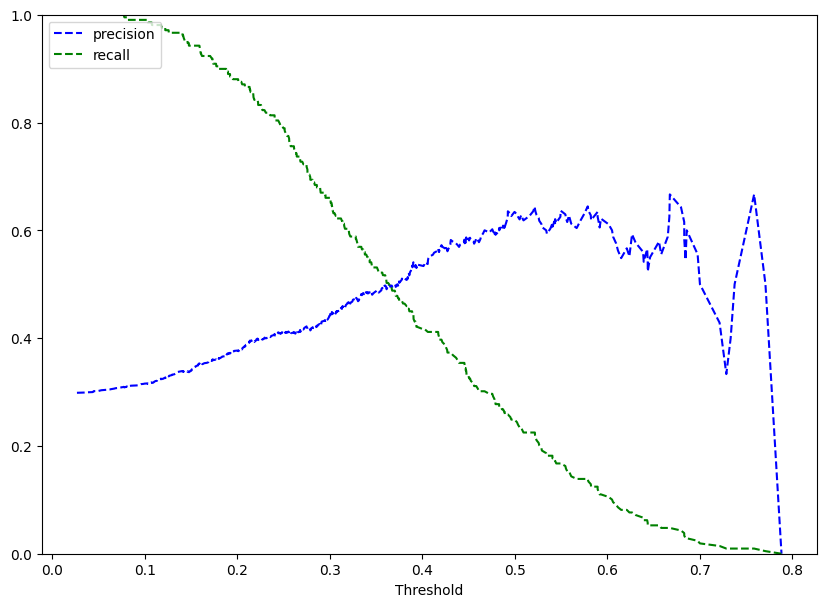

In [48]:
y_scores = lg.predict_proba(X_train)[:, 1]
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* At threshold around 0.37 we will get equal precision and recall but taking a step back and selecting value around 0.34 will provide a higher recall and a good precision.

In [49]:
# setting the threshold
optimal_threshold_curve = 0.34

#### Checking model performance on training set

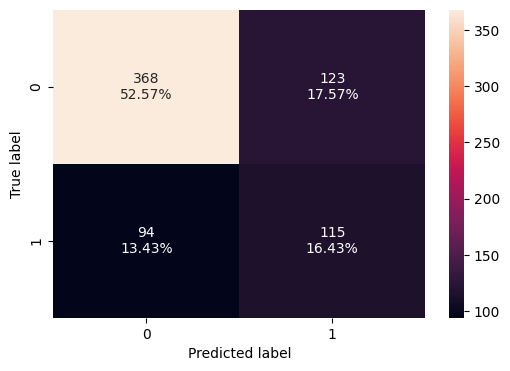

In [50]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)

In [51]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_train, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.69,0.550239,0.483193,0.514541


* Recall has improved as compared to the initial model.
* Model with threshold as 0.32 was giving a better recall.

### Model Performance Summary

In [52]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.33 Threshold",
    "Logistic Regression-0.37 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.33 Threshold,Logistic Regression-0.37 Threshold
Accuracy,0.731429,0.595714,0.690000
Recall,0.244019,0.799043,0.550239
Precision,0.629630,0.409314,0.483193
F1,0.351724,0.541329,0.514541


### Let's check the performance on the test set

**Using the model with default threshold**

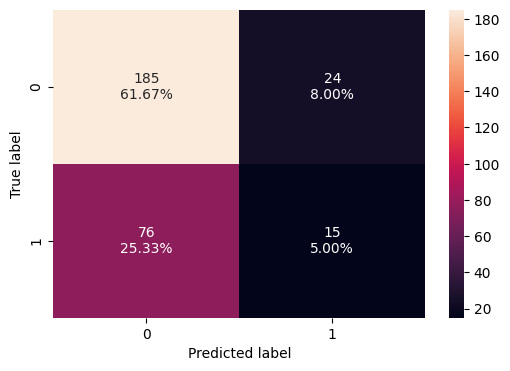

In [53]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(lg, X_test, y_test)

In [54]:
log_reg_model_test_perf = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test
)

print("Test set performance:")
log_reg_model_test_perf

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.666667,0.164835,0.384615,0.230769


* ROC-AUC on test set

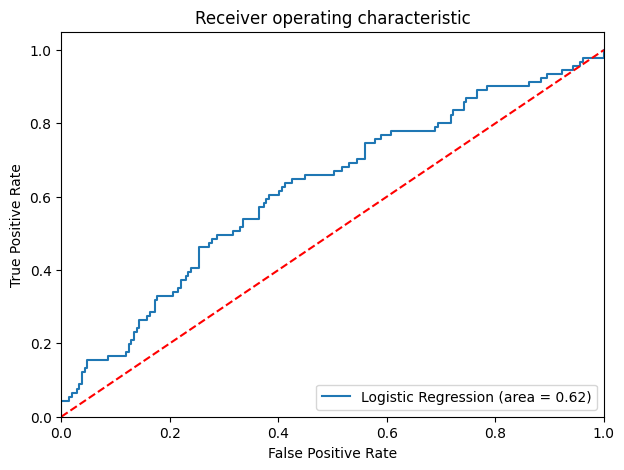

In [55]:
logit_roc_auc_test = roc_auc_score(y_test, lg.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, lg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

**Using the model with threshold of 0.32**

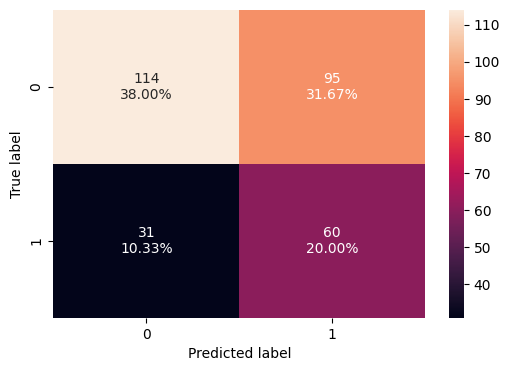

In [56]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)

In [57]:
# checking model performance for this model
log_reg_model_test_perf_threshold_auc_roc = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_auc_roc
)
print("Test set performance:")
log_reg_model_test_perf_threshold_auc_roc

Test set performance:


,Accuracy,Recall,Precision,F1
0,0.58,0.659341,0.387097,0.487805


**Using the model with threshold 0.34**

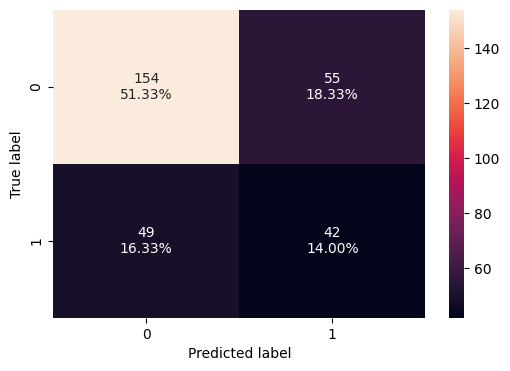

In [58]:
# creating confusion matrix
confusion_matrix_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)

In [59]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_sklearn_with_threshold(
    lg, X_test, y_test, threshold=optimal_threshold_curve
)
print("Test performance:")
log_reg_model_test_perf_threshold_curve

Test performance:


,Accuracy,Recall,Precision,F1
0,0.653333,0.461538,0.43299,0.446809


### Model performance comparison

In [60]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_model_train_perf.T,
        log_reg_model_train_perf_threshold_auc_roc.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.32 Threshold",
    "Logistic Regression-0.34 Threshold",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.32 Threshold,Logistic Regression-0.34 Threshold
Accuracy,0.731429,0.595714,0.690000
Recall,0.244019,0.799043,0.550239
Precision,0.629630,0.409314,0.483193
F1,0.351724,0.541329,0.514541


In [61]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        log_reg_model_test_perf.T,
        log_reg_model_test_perf_threshold_auc_roc.T,
        log_reg_model_test_perf_threshold_curve.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression sklearn",
    "Logistic Regression-0.32 Threshold",
    "Logistic Regression-0.34 Threshold",
]

print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Logistic Regression sklearn,Logistic Regression-0.32 Threshold,Logistic Regression-0.34 Threshold
Accuracy,0.666667,0.580000,0.653333
Recall,0.164835,0.659341,0.461538
Precision,0.384615,0.387097,0.432990
F1,0.230769,0.487805,0.446809


### Conclusion

* By changing the threshold of the logistic regression model we were able to see a significant improvement in the model performance.
* The model achieved a recall of 0.58 on the training set with threshold set at 0.32.

#### Recommendations

- From our logistic regression model we identified that Duration is a significant predictor of a customer being a defaulter. 
- Bank should target more male customers as they have lesser odds of defaulting.
- We saw in our analysis that customers with a little or moderate amount in saving or checking accounts are more likely to default.  The bank can be more strict with its rules or interest rates to compensate for the risk.
- We saw that customers who have rented or free housing are more likely to default. The bank should keep more details about such customers like hometown addresses, etc. to be able to track them.
- Our analysis showed that younger customers are slightly more likely to default. The bank can alter its policies to deal with this.

#### Thank You !!!